<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%207/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Dataset

In [0]:
from keras import backend as K
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, SeparableConv2D, Concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from IPython.display import Image

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


Plot random images from each class

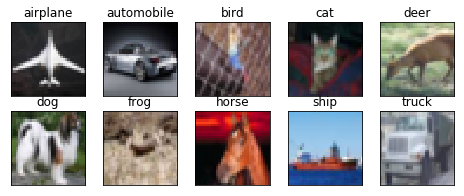

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Rescale the images and change to labels to one-hot vectors

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model Architecture



In [0]:
# We use this function to match the dimensions of matrics during concatenation
def space_to_depth_x2(x):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2)

Implementation of eNAS Architecture

To identify the skip connections in the network, we first number the nodes of the network as follows-

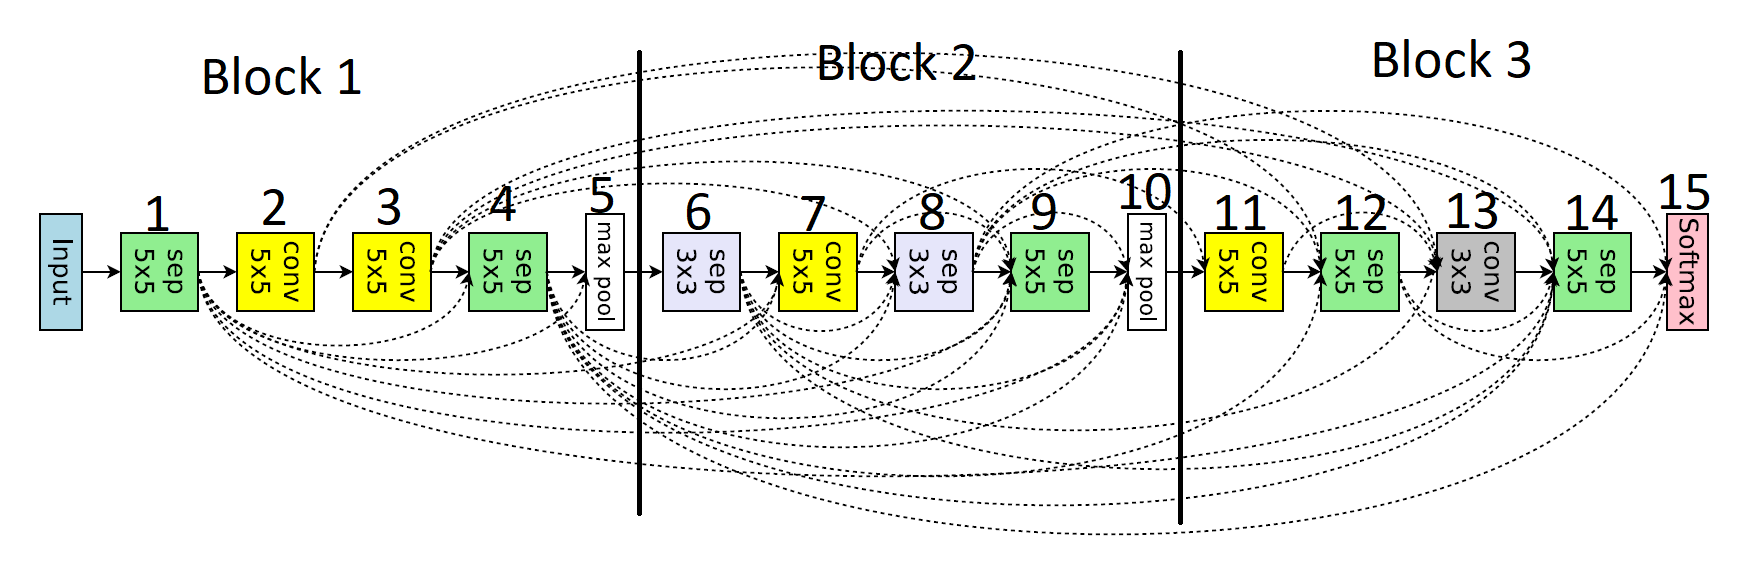

In [5]:
Image('eNAS Architecture.PNG', width=841, height=280)

The table for Skip Connections is given below-

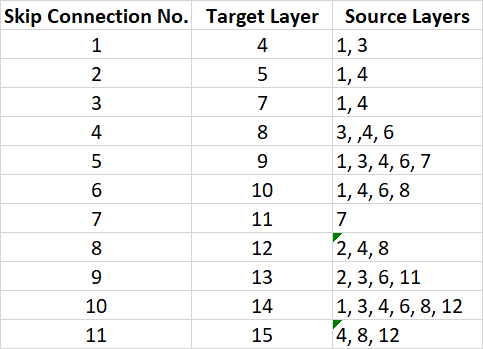

In [6]:
Image('Skip Connection Table.png')

In [0]:
input = Input(shape=(32, 32, 3))

# Block 1

# The number of channels are increased with every layer in each block

layer1 = SeparableConv2D(32, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(input) # RF = 5 ; Output Size = 32
layer1 = BatchNormalization()(layer1)
layer1 = Activation("relu")(layer1)

layer2 = Conv2D(64, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(layer1) # 9 ; 32
layer2 = BatchNormalization()(layer2)
layer2 = Activation("relu")(layer2)

layer3 = Conv2D(128, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(layer2) # 13 ; 32
layer3 = BatchNormalization()(layer3)
layer3 = Activation("relu")(layer3)

# 1st skip connection. The sequence of skip connections is separate from the layers.
skip_1 = Concatenate(axis=-1)([layer1, layer3])

#Each skip connection is followed by a 1x1 convolution, BN and relu as mentioned in the paper
skip_1 = Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_1)
skip_1 = BatchNormalization()(skip_1)
skip_1 = Activation("relu")(skip_1)

layer4 = SeparableConv2D(256, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_1) # 17 ; 32
layer4 = BatchNormalization()(layer4)
layer4 = Activation("relu")(layer4)

# 2nd skip connection
skip_2 = Concatenate(axis=-1)([layer1, layer4])
skip_2 = Conv2D(256, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_2)
skip_2 = BatchNormalization()(skip_2)
skip_2 = Activation("relu")(skip_2)

layer5 = MaxPooling2D(pool_size=(2, 2))(skip_2) # 18 ; 16

# End of First Block 

# Block 2

layer6 = SeparableConv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(layer5) # 22 ; 16
layer6 = BatchNormalization()(layer6)
layer6 = Activation("relu")(layer6)

# 3rd Skip Connection

# If a layer is passed from First Block, we use space_to_depth function to reduce their dimensions by a factor of 2
# The depth_x_y is named with x=nth skip connection, y=layer being passed to concatenate
depth_3_1 = Lambda(space_to_depth_x2)(layer1)
depth_3_4 = Lambda(space_to_depth_x2)(layer4)
skip_3 = Concatenate(axis=-1)([depth_3_1, depth_3_4, layer6])
skip_3 = Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_3)
skip_3 = BatchNormalization()(skip_3)
skip_3 = Activation("relu")(skip_3)

layer7 = Conv2D(128, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_3) # 30 ; 16
layer7 = BatchNormalization()(layer7)
layer7 = Activation("relu")(layer7)

# 4th Skip Connection
depth_4_3 = Lambda(space_to_depth_x2)(layer3)
depth_4_4 = Lambda(space_to_depth_x2)(layer4)
skip_4 = Concatenate(axis=-1)([depth_4_3, depth_4_4, layer6, layer7])
skip_4 = Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_4)
skip_4 = BatchNormalization()(skip_4)
skip_4 = Activation("relu")(skip_4)

layer8 = SeparableConv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_4) # 34 ; 16
layer8 = BatchNormalization()(layer8)
layer8 = Activation("relu")(layer8)

# 5th Skip Connection
depth_5_1 = Lambda(space_to_depth_x2)(layer1)
depth_5_3 = Lambda(space_to_depth_x2)(layer3)
depth_5_4 = Lambda(space_to_depth_x2)(layer4)
skip_5 = Concatenate(axis=-1)([depth_5_1, depth_5_3, depth_5_4, layer6, layer7, layer8])
skip_5 = Conv2D(256, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_5)
skip_5 = BatchNormalization()(skip_5)
skip_5 = Activation("relu")(skip_5)

layer9 = SeparableConv2D(512, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_5) # 42 ; 16
layer9 = BatchNormalization()(layer9)
layer9 = Activation("relu")(layer9)

# 6th Skip Connection
depth_6_1 = Lambda(space_to_depth_x2)(layer1)
depth_6_4 = Lambda(space_to_depth_x2)(layer4)
skip_6 = Concatenate(axis=-1)([depth_6_1, depth_6_4, layer6, layer8, layer9])
skip_6 = Conv2D(512, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_6)
skip_6 = BatchNormalization()(skip_6)
skip_6 = Activation("relu")(skip_6)

layer10 = MaxPooling2D(pool_size=(2, 2))(skip_6) # 44 ; 8

# End of Second Block

# Block 3

# 7th Skip Connection
depth_7_7 = Lambda(space_to_depth_x2)(layer7)
skip_7 = Concatenate(axis=-1)([depth_7_7, layer10])
skip_7 = Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_7)
skip_7 = BatchNormalization()(skip_7)
skip_7 = Activation("relu")(skip_7)

layer11 = Conv2D(64, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_7) # 60 ; 8
layer11 = BatchNormalization()(layer11)
layer11 = Activation("relu")(layer11)

# 8th Skip Connection

# If a layer is passed from First Block, we use space_to_depth function twice to reduce their dimension by a factor of 4
# If a layer is passed from Second Block, we use space_to_depth function once to reduce their dimension by a factor of 2
depth_8_2 = Lambda(space_to_depth_x2)(layer2)
depth_8_2 = Lambda(space_to_depth_x2)(depth_8_2)
depth_8_4 = Lambda(space_to_depth_x2)(layer4)
depth_8_4 = Lambda(space_to_depth_x2)(depth_8_4)
depth_8_8 = Lambda(space_to_depth_x2)(layer8)
skip_8 = Concatenate(axis=-1)([depth_8_2, depth_8_4, depth_8_8, layer11])
skip_8 = Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_8)
skip_8 = BatchNormalization()(skip_8)
skip_8 = Activation("relu")(skip_8)

layer12 = SeparableConv2D(128, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_8) # 76 ; 8
layer12 = BatchNormalization()(layer12)
layer12 = Activation("relu")(layer12)

# 9th Skip Connection
depth_9_2 = Lambda(space_to_depth_x2)(layer2)
depth_9_2 = Lambda(space_to_depth_x2)(depth_9_2)
depth_9_3 = Lambda(space_to_depth_x2)(layer3)
depth_9_3 = Lambda(space_to_depth_x2)(depth_9_3)
depth_9_6 = Lambda(space_to_depth_x2)(layer6)
skip_9 = Concatenate(axis=-1)([depth_9_2, depth_9_3, depth_9_6, layer11, layer12])
skip_9 = Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_9)
skip_9 = BatchNormalization()(skip_9)
skip_9 = Activation("relu")(skip_9)

layer13 = Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_9) # 84 ; 8
layer13 = BatchNormalization()(layer13)
layer13 = Activation("relu")(layer13)

# 10th Skip Connection
depth_10_1 = Lambda(space_to_depth_x2)(layer1)
depth_10_1 = Lambda(space_to_depth_x2)(depth_10_1)
depth_10_3 = Lambda(space_to_depth_x2)(layer3)
depth_10_3 = Lambda(space_to_depth_x2)(depth_10_3)
depth_10_4 = Lambda(space_to_depth_x2)(layer4)
depth_10_4 = Lambda(space_to_depth_x2)(depth_10_4)
depth_10_6 = Lambda(space_to_depth_x2)(layer6)
depth_10_8 = Lambda(space_to_depth_x2)(layer8)
skip_10 = Concatenate(axis=-1)([depth_10_1, depth_10_3, depth_10_4, depth_10_6, depth_10_8, layer12, layer13])
skip_10 = Conv2D(256, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_10)
skip_10 = BatchNormalization()(skip_10)
skip_10 = Activation("relu")(skip_10)

layer14 = SeparableConv2D(512, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_10) # 100 ; 8
layer14 = BatchNormalization()(layer14)
layer14 = Activation("relu")(layer14)

# 11th Skip Connection
depth_11_4 = Lambda(space_to_depth_x2)(layer4)
depth_11_4 = Lambda(space_to_depth_x2)(depth_11_4)
depth_11_8 = Lambda(space_to_depth_x2)(layer8)
skip_11 = Concatenate(axis=-1)([depth_11_4, depth_11_8, layer12, layer14])
skip_11 = Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_11)
skip_11 = BatchNormalization()(skip_11)
skip_11 = Activation("relu")(skip_11)

# End of Third Block

# 1x1 Convolution to bring the number of channels to the output number of classes
layer15 = Conv2D(10, (1,1), strides=(1,1), padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(skip_11) # 100 ; 8

# GlobalAveragePooling to take the average of all the values of a channel
layer15 = GlobalAveragePooling2D(data_format=None)(layer15)

layer16 = Activation('softmax')(layer15)

output = layer16

model = Model(inputs=[input], outputs=[output])
model.summary()

W0617 02:53:56.084422 140555130959744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 02:53:56.126364 140555130959744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 02:53:56.135112 140555130959744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 02:53:56.179074 140555130959744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 02:53:56.180042 1405551309

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   171         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
# LRScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Use Adam optimizer with a starting value of 0.003
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0617 02:54:01.509493 140555130959744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')

# Use ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/EVA_Asgn_7B_2.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Create generator object for training and testing data
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             horizontal_flip=True)

train_generator = datagen.flow(train_features, train_labels, batch_size = 128)

validation_generator = datagen.flow(test_features, test_labels, batch_size = 128)

# Train the model for 25 epochs
model.fit_generator(train_generator, steps_per_epoch=np.ceil(len(train_features) / 128), epochs=25, verbose=1, validation_data=validation_generator, 
                    validation_steps = np.ceil(len(test_features)/128), callbacks=[LearningRateScheduler(scheduler, verbose=1), checkpoint])


W0617 02:54:54.401314 140555130959744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
391/391 [==============================] - 190s 487ms/step - loss: 1.5004 - acc: 0.5184 - val_loss: 1.7308 - val_acc: 0.4728

Epoch 00001: val_acc improved from -inf to 0.47280, saving model to /content/drive/My Drive/Colab Notebooks/EVA_Asgn_7B_2.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
391/391 [==============================] - 182s 464ms/step - loss: 1.0572 - acc: 0.6898 - val_loss: 1.4301 - val_acc: 0.5757

Epoch 00002: val_acc improved from 0.47280 to 0.57570, saving model to /content/drive/My Drive/Colab Notebooks/EVA_Asgn_7B_2.hdf5
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
391/391 [==============================] - 185s 473ms/step - loss: 0.8796 - acc: 0.7588 - val_loss: 1.3457 - val_acc: 0.6316

Epoch 00003: val_acc improved from 0.57570 to 0.63160, saving model to /content/drive/My Drive/Colab Notebooks/EVA_Asgn_7B_2.

This model achieves a highest validation accuracy of 85.21%